<a href="https://colab.research.google.com/github/Cesare-Caputo/PyPSA-gridtracer/blob/main/pypsa_network_inference_from_towers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#setup

In [ ]:
!pip install geopandas rtree
!pip install gridfinder

     |████████████████████████████████| 1.0 MB 7.9 MB/s 
     |████████████████████████████████| 994 kB 35.5 MB/s 
     |████████████████████████████████| 6.3 MB 36.7 MB/s 
     |████████████████████████████████| 16.7 MB 354 kB/s 
     |████████████████████████████████| 19.3 MB 81.0 MB/s 
  Created wheel for gridfinder: filename=gridfinder-1.0.0-py3-none-any.whl size=11518 sha256=f11ec754a13d7b8b531231b66df276166e9aee20612de2a6800010ae66fa3860
  Stored in directory: /root/.cache/pip/wheels/11/55/ba/21619467231795a6e47dfc4d1af62db310e69aad6aa9ed1621
Successfully built gridfinder


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
datapath = '/content/drive/MyDrive/PyPSA_Africa_images/datasets'

import sys
sys.argv = ['']


# Add pypsa africa tool
import os

import sys
sys.path.append('/content/drive/MyDrive/PyPSA_Africa_images/detect_energy/src/')


from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt



import os
os.chdir('/content/drive/My Drive/PyPSA_Africa_images/')
import importlib
import sys
sys.path.append(os.getcwd()+'/detect_energy/image_download/')
import geopandas as gpd
import pandas as pd

In [ ]:
from pathlib import Path
folder_out = Path('test_output')
guess_skeletonized_out = folder_out / 'guess_skel.tif'

# helper functions

In [ ]:
def m_distance_sline_all_towers(gh_coord_test):
  gh_coord_test_crs = gh_coord_test.to_crs('EPSG:5234')
  gh_coord_test_crs2 = gh_coord_test_crs.shift()
  dists =[]
  for gv in range(len(gh_coord_test_crs)):
    pt = gh_coord_test_crs[gv]
    dists.append(gh_coord_test_crs.distance(pt))
  return dists

In [ ]:
def unpack_all_tower_coords(gh_coord_test):
  labeled_twr_coords =[]
  for i in range(len(gh_coord_test.geometry)):
      i_coord = list(gh_coord_test.geometry.iloc[i].coords)
      mylist_n = [j for i in i_coord for j in i] # unpack list so linestring format compatible with EE
      labeled_twr_coords.append(mylist_n)
  return labeled_twr_coords

In [ ]:
def return_idx_twr_gridded_lines(cell, n_cells): #cell here is df containing both shapely polygon grids and original tower point markers , ncells to number of cells in x coordinate system for now
  # total area for the grid
  gdf = cell
  xmin, ymin, xmax, ymax= gdf.total_bounds
  cell_size = (xmax-xmin)/n_cells

  gps = []
  #find location in grid ####
  for i in range(len(cell)):
    if cell["n_lines"][i] ==1:
      #print(i)
      twr_grid_cnt = list(cell.iloc[i].geometry.centroid.coords)
      yic = twr_grid_cnt[0][1]
      xic = twr_grid_cnt[0][0]
  #### now retrieve integer indexing #####
      yi = int((yic- ymin) / cell_size)
      xi = int((xic- xmin) / cell_size)

      gps.append((yi,xi))
  return gps


def return_idx_twr_gridded_(cell, n_cells): #cell here is df containing both shapely polygon grids and original tower point markers , ncells to number of cells in x coordinate system for now
  # total area for the grid
  gdf = cell
  xmin, ymin, xmax, ymax= gdf.total_bounds
  cell_size = (xmax-xmin)/n_cells

  gps = []
  #find location in grid ####
  for i in range(len(cell)):
    if cell["n_twr"][i] ==1:
      #print(i)
      twr_grid_cnt = list(cell.iloc[i].geometry.centroid.coords)
      yic = twr_grid_cnt[0][1]
      xic = twr_grid_cnt[0][0]
  #### now retrieve integer indexing #####
      yi = int((yic- ymin) / cell_size)
      xi = int((xic- xmin) / cell_size)

      gps.append((yi,xi))
  return gps


In [ ]:
#TODO- MAKE UPDATED VERSION WHICH ONLY TAKES CELL DF AS INPUT
def lines_df_to_2d_target_array(cell, n_cells):

  gdf = cell
  xmin, ymin, xmax, ymax= gdf.total_bounds
  cell_size = (xmax-xmin)/n_cells

  # define number of x and y cells used for indexing
  nxcell = int((xmax - xmin) / cell_size)
  nycell = int((ymax - ymin) / cell_size)

  twr_pts_idx = return_idx_twr_gridded_lines(cell, n_cells)

  points = twr_pts_idx
  targets = np.zeros((int(nycell+1), int(nxcell+1)))
  targets[tuple(np.array(points).T)] = 1
  #targets[tuple(np.array(points))] = 1
  #equal costs for all cells - excluding road info etc
  costs = np.ones((int(nycell+1), int(nxcell+1)))

  ## flip to be consistent with original gridded
  t = np.flip(targets, 0)
  c = np.flip(costs, 0)

  return t, c

In [ ]:
def save_raster(path, raster, affine, crs=None, nodata=0):
    """Save a raster to the specified file.
    Parameters
    ----------
    file : str
        Output file path
    raster : numpy.array
        2D numpy array containing raster values
    affine: affine.Affine
        Affine transformation for the raster
    crs: str, proj.Proj, optional (default EPSG4326)
        CRS for the raster
    """

    path = Path(path)
    if not path.parents[0].exists():
        path.parents[0].mkdir(parents=True, exist_ok=True)

    if not crs:
        crs = "+proj=latlong"

    filtered_out = rasterio.open(
        path,
        "w",
        driver="GTiff",
        height=raster.shape[0],
        width=raster.shape[1],
        count=1,
        dtype=raster.dtype,
        crs=crs,
        transform=affine,
        nodata=nodata,
    )
    filtered_out.write(raster, 1)
    filtered_out.close()

## geoconversions

In [ ]:
def convert_guess_to_gdf_multilines(thinned_network_guess, original_gdf):

  gdf = original_gdf
  xmin, ymin, xmax, ymax= gdf.total_bounds
  cell_size = (xmax-xmin)/n_cells

  #arr = network_guess
  arr = np.flip(thinned_network_guess,0)

  max_row = arr.shape[0]
  max_col = arr.shape[1]

  lines = []

  for row in range(0, max_row):
      for col in range(0, max_col):
          loc = (row, col)
          if arr[loc] == 1:
              for i in range(-1, 2):
                  for j in range(-1, 2):
                      next_row = row + i
                      next_col = col + j
                      next_loc = (next_row, next_col)

                      # ensure we're within bounds
                      # ensure we're not looking at the same spot
                      if (
                          next_row < 0
                          or next_col < 0
                          or next_row >= max_row
                          or next_col >= max_col
                          or next_loc == loc
                      ):
                          continue

                      if arr[next_loc] == 1:
                          line = (loc, next_loc)
                          rev = (line[1], line[0])
                          if line not in lines and rev not in lines:
                              lines.append(line)


  real_lines = []
  for line in lines:
      xi = line[0][1]
      yi = line[0][0]
      ycoord = yi*cell_size + ymin
      xcoord = xi*cell_size + xmin
  #second set of points
      xi2 = line[1][1]
      yi2 = line[1][0]
      ycoord2 = yi2*cell_size + ymin
      xcoord2 = xi2*cell_size + xmin


      real =((xcoord, ycoord), (xcoord2, ycoord2))
      real_lines.append(real)


  shapes = []
  for line in real_lines:
    #print(line[1])
    shapes.append(LineString([Point(line[0]), Point(line[1])]).wkt)


  guess_gdf = pd.DataFrame(shapes)
  geometry = guess_gdf[0].map(shapely.wkt.loads)
  guess_gdf = guess_gdf.drop(0, axis=1)
  guess_gdf = gpd.GeoDataFrame(guess_gdf, geometry=geometry)

  guess_gdf = guess_gdf.set_crs('epsg:4326')

  guess_gdf["same"] = 0
  guess_gdf = guess_gdf.dissolve(by="same")
  guess_gdf = guess_gdf.to_crs(epsg=4326)

  return guess_gdf

In [ ]:
def convert_guess_to_gdf_lines(thinned_network_guess, original_gdf):

  gdf = original_gdf
  xmin, ymin, xmax, ymax= gdf.total_bounds
  cell_size = (xmax-xmin)/n_cells


  arr = thinned_network_guess

  max_row = arr.shape[0]
  max_col = arr.shape[1]

  lines = []
  line_pts = []

  for row in range(0, max_row):
      for col in range(0, max_col):
          loc = (row, col)
          if arr[loc] == 1:
            line_pts.append(loc)


  real_lines_pts = []
  for line in line_pts:
      xi = line[1]
      yi = line[0]
      ycoord = yi*cell_size + ymin
      xcoord = xi*cell_size + xmin

      real =(xcoord, ycoord)
      real_lines_pts.append(real)

  l = LineString(real_lines_pts)
  df = pd.DataFrame({"same" :[0 ], "network": [l]})
  df.head()
  line_guess_gdf = gpd.GeoDataFrame(df, geometry=df.network)
  line_guess_gdf = line_guess_gdf.set_crs('epsg:4326')
  line_guess_gdf = line_guess_gdf.drop("network", axis=1)
  return line_guess_gdf

In [ ]:
def convert_guess_to_gdf_pts(thinned_network_guess, original_gdf):
  gdf = original_gdf
  xmin, ymin, xmax, ymax= gdf.total_bounds
  cell_size = (xmax-xmin)/n_cells
  arr = thinned_network_guess

  max_row = arr.shape[0]
  max_col = arr.shape[1]

  lines = []
  line_pts = []

  for row in range(0, max_row):
      for col in range(0, max_col):
          loc = (row, col)
          if arr[loc] == 1:
            line_pts.append(loc)


  real_lines_pts = []
  for line in line_pts:
      xi = line[1]
      yi = line[0]
      ycoord = yi*cell_size + ymin
      xcoord = xi*cell_size + xmin

      real =(xcoord, ycoord)
      real_lines_pts.append(real)


  shapes = []
  for line in real_lines_pts:
    #print(line[1])
    shapes.append(Point(line[0],line[1]).wkt)


  guess_gdf = pd.DataFrame(shapes)
  geometry = guess_gdf[0].map(shapely.wkt.loads)
  guess_gdf = guess_gdf.drop(0, axis=1)
  guess_gdf = gpd.GeoDataFrame(guess_gdf, geometry=geometry)

  guess_gdf = guess_gdf.set_crs('epsg:4326')

  guess_gdf["same"] = 0
  guess_gdf = guess_gdf.dissolve(by="same")
  guess_gdf = guess_gdf.to_crs(epsg=4326)
  return guess_gdf

# Network inference algos

In [ ]:
from heapq import heapify, heappush, heappop
import pickle
import rasterio
from IPython.display import display, Markdown
from math import sqrt
from pathlib import Path

import numpy as np
import pandas as pd
import geopandas as gpd
from skimage.morphology import skeletonize
import shapely.wkt
from shapely.geometry import Point, LineString, MultiLineString
import rasterio
from rasterio.features import rasterize
from rasterio.transform import xy
import gridfinder as gf

In [ ]:
def optimise(
    targets,
    costs,
    start,
    jupyter=False,
    animate=False,
    affine=None,
    animate_path=None,
    silent=False,
):
    """Run the Dijkstra algorithm for the supplied arrays.
    Parameters
    ----------
    targets : numpy array
        2D array of targets which includes both towers and known town/villages.
    costs : numpy array
        2D array of costs.
    start : tuple
        Two-element tuple with row, col of starting point.
    jupyter : boolean, optional (default False)
        Whether the code is being run from a Jupyter Notebook.
    Returns
    -------
    dist : numpy array
        2D array with the distance (in cells) of each point from a 'found'
        on-grid point. Values of 0 imply that cell is part of an MV grid line.
    """

    max_i = costs.shape[0]
    max_j = costs.shape[1]

    visited = np.zeros_like(targets, dtype=np.int8)
    dist = np.full_like(costs, np.nan, dtype=np.float32)

    # want to set this to dtype='int32, int32'
    # but then the if type(prev_loc) == tuple check will break
    # becuas it gets instantiated with tuples
    prev = np.full_like(costs, np.nan, dtype=object)

    dist[start] = 0

    #       dist, loc
    queue = [[0, start]]
    heapify(queue)

    def zero_and_heap_path(loc):
        """Zero the location's distance value and follow upstream doing same.
        Parameters
        ----------
        loc : tuple
            row, col of current point.
        """

        if not dist[loc] == 0:
            dist[loc] = 0
            visited[loc] = 1

            heappush(queue, [0, loc])
            prev_loc = prev[loc]

            if type(prev_loc) == tuple:
                zero_and_heap_path(prev_loc)

    counter = 0
    progress = 0
    max_cells = targets.shape[0] * targets.shape[1]
    if jupyter:
        handle = display(Markdown(""), display_id=True)

    while len(queue):
        current = heappop(queue)
        current_loc = current[1]
        current_i = current_loc[0]
        current_j = current_loc[1]
        current_dist = dist[current_loc]

        for x in range(-1, 2):
            for y in range(-1, 2):
                next_i = current_i + x
                next_j = current_j + y
                next_loc = (next_i, next_j)

                # ensure we're within bounds
                if next_i < 0 or next_j < 0 or next_i >= max_i or next_j >= max_j:
                    continue

                # ensure we're not looking at the same spot
                if next_loc == current_loc:
                    continue

                # skip if we've already set dist to 0
                if dist[next_loc] == 0:
                    continue

                # if the location is connected
                if targets[next_loc]:
                    prev[next_loc] = current_loc
                    zero_and_heap_path(next_loc)

                # otherwise it's a normal queue cell
                else:
                    dist_add = costs[next_loc]
                    if x == 0 or y == 0:  # if this cell is  up/down/left/right
                        dist_add *= 1
                    else:  # or if it's diagonal
                        dist_add *= sqrt(2)

                    next_dist = current_dist + dist_add

                    if visited[next_loc]:
                        if next_dist < dist[next_loc]:
                            dist[next_loc] = next_dist
                            prev[next_loc] = current_loc
                            heappush(queue, [next_dist, next_loc])

                    else:
                        heappush(queue, [next_dist, next_loc])
                        visited[next_loc] = 1
                        dist[next_loc] = next_dist
                        prev[next_loc] = current_loc

                        counter += 1
                        progress_new = 100 * counter / max_cells
                        if int(progress_new) > int(progress):
                            progress = progress_new
                            message = f"{progress:.2f} %"
                            if jupyter:
                                handle.update(message)
                            elif not silent:
                                print(message)
                            if animate:
                                i = int(progress)
                                path = os.path.join(animate_path, f"arr{i:03d}.tif")
                                save_raster(path, dist, affine)

    return dist

In [ ]:
def threshold(dists_in, cutoff=0.0):
    """Convert distance array into binary array of connected locations.
    Parameters
    ----------
    dists_in : path-like or numpy array
        2D array output from gridfinder algorithm.
    cutoff : float, optional (default 0.5.)
        Cutoff value below which consider the cells to be grid.
    Returns
    -------
    guess : numpy array
        Binary representation of input array.
    affine: affine.Affine
        Affine transformation for raster.
    """
    if isinstance(dists_in, (str, Path)):
        dists_rd = rasterio.open(dists_in)
        dists_r = dists_rd.read(1)
        affine = dists_rd.transform

        guess = dists_r.copy()
        guess[dists_r > cutoff] = 0
        guess[dists_r <= cutoff] = 1

        return guess, affine

    elif isinstance(dists_in, np.ndarray):
        guess = dists_in.copy()
        guess[dists_in > cutoff] = 0
        guess[dists_in <= cutoff] = 1

        return guess

    else:
        raise ValueError


def thin(guess_in):
    """
    Use scikit-image skeletonize to 'thin' the guess raster.
    Parameters
    ----------
    guess_in : path-like or 2D array
        Output from threshold().
    Returns
    -------
    guess_skel : numpy array
        Thinned version.
    affine : Affine
        Only if path-like supplied.
    """

    if isinstance(guess_in, (str, Path)):
        guess_rd = rasterio.open(guess_in)
        guess_arr = guess_rd.read(1)
        affine = guess_rd.transform

        guess_skel = skeletonize(guess_arr)
        guess_skel = guess_skel.astype("int32")

        return guess_skel, affine

    elif isinstance(guess_in, np.ndarray):
        guess_skel = skeletonize(guess_in)
        guess_skel = guess_skel.astype("int32")

        return guess_skel

    else:
        raise ValueError

In [ ]:
def pts_df_to_2d_target_array(cell, n_cells):

  gdf = cell
  xmin, ymin, xmax, ymax= gdf.total_bounds
  cell_size = (xmax-xmin)/n_cells

  # define number of x and y cells used for indexing
  nxcell = int((xmax - xmin) / cell_size)
  nycell = int((ymax - ymin) / cell_size)

  twr_pts_idx = return_idx_twr_gridded(cell, n_cells)

  points = twr_pts_idx
  targets = np.zeros((int(nycell+1), int(nxcell+1)))
  targets[tuple(np.array(points).T)] = 1
  #targets[tuple(np.array(points))] = 1
  #equal costs for all cells - excluding road info etc
  costs = np.ones((int(nycell+1), int(nxcell+1)))

  ## flip to be consistent with original gridded
  t = np.flip(targets, 0)
  c = np.flip(costs, 0)

  return t, c

In [ ]:
def network_inference_simple(gdf, n_cells ):
  # total area for the grid
  xmin, ymin, xmax, ymax= gdf.total_bounds
  # how many cells for range of x values investigated - can be customized for y if needed
  #n_cells=30
  cell_size = (xmax-xmin)/n_cells
  # projection of the grid
  crs = "+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs"
  # create the cells in a loop
  grid_cells = []
  for x0 in np.arange(xmin, xmax+cell_size, cell_size ):
      for y0 in np.arange(ymin, ymax+cell_size, cell_size):
          # bounds
          x1 = x0-cell_size
          y1 = y0+cell_size
          grid_cells.append( shapely.geometry.box(x0, y0, x1, y1)  )
  cell = gpd.GeoDataFrame(grid_cells, columns=['geometry'],
                                  crs=crs)


  merged = gpd.sjoin(gdf, cell, how='left', op='within')

  clean_merge = merged.drop(labels =['tags.power', 'tags.material', 'tags.height', 'tags.structure',
       'tags.line_management', 'Type', 'Country'], axis = 1)

  ## removing nan which can cause error
  merged2 = clean_merge.dropna(axis = 0, how = 'any')


  # make a simple count variable that we can sum
  merged2['n_twr']=1
  # Compute stats per grid cell -- aggregate fires to grid cells with dissolve
  dissolve = merged2.dissolve(by="index_right", aggfunc="count")
  # put this into cell
  cell.loc[dissolve.index, 'n_twr'] = dissolve.n_twr.values


#### obtain 2d numpy representation to run gridfinder algo
  targets, costs = pts_df_to_2d_target_array(cell, n_cells)

  twr_pts_idx = return_idx_twr_gridded(cell, n_cells)

  points = twr_pts_idx

  start = points[0]
  dist = optimise(targets, costs, start, jupyter=True)

  guess = threshold(dist, cutoff = 0.0)

  guess_skel = thin(guess)

  return guess, guess_skel


In [ ]:
def network_inference_costs(gdf, n_cells , costs_osm):
  # total area for the grid
  xmin, ymin, xmax, ymax= gdf.total_bounds
  # how many cells for range of x values investigated - can be customized for y if needed
  #n_cells=30
  cell_size = (xmax-xmin)/n_cells
  # projection of the grid
  crs = "+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs"
  # create the cells in a loop
  grid_cells = []
  for x0 in np.arange(xmin, xmax+cell_size, cell_size ):
      for y0 in np.arange(ymin, ymax+cell_size, cell_size):
          # bounds
          x1 = x0-cell_size
          y1 = y0+cell_size
          grid_cells.append( shapely.geometry.box(x0, y0, x1, y1)  )
  cell = gpd.GeoDataFrame(grid_cells, columns=['geometry'],
                                  crs=crs)


  merged = gpd.sjoin(gdf, cell, how='left', op='within')

  clean_merge = merged.drop(labels =['tags.power', 'tags.material', 'tags.height', 'tags.structure',
       'tags.line_management', 'Type', 'Country'], axis = 1)

  ## removing nan which can cause error
  merged2 = clean_merge.dropna(axis = 0, how = 'any')


  # make a simple count variable that we can sum
  merged2['n_twr']=1
  # Compute stats per grid cell -- aggregate fires to grid cells with dissolve
  dissolve = merged2.dissolve(by="index_right", aggfunc="count")
  # put this into cell
  cell.loc[dissolve.index, 'n_twr'] = dissolve.n_twr.values


#### obtain 2d numpy representation to run gridfinder algo
  targets, costs = pts_df_to_2d_target_array(cell, n_cells)


  costs = costs_osm

  twr_pts_idx = return_idx_twr_gridded(cell, n_cells)

  points = twr_pts_idx

  start = points[0]
  dist = optimise(targets, costs, start, jupyter=True)

  guess = threshold(dist, cutoff = 0.0)

  guess_skel = thin(guess)

  return guess, guess_skel

## test toy example

In [ ]:
targets = np.zeros((10, 10))
points = [(0, 0), (3, 5), (1, 7), (9, 9)]
targets[tuple(np.array(points).T)] = 1
costs = np.random.rand(*targets.shape)

In [ ]:
targets
costs

In [ ]:
start = points[0]
dist = optimise(targets, costs, start, jupyter=True)

'96.00 %'

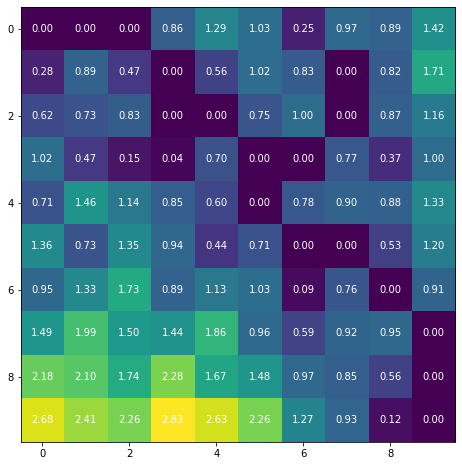

In [ ]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.imshow(dist, cmap='viridis')
for (j,i),label in np.ndenumerate(dist):
    ax.text(i, j, f'{label:.2f}', ha='center', va='center', color='white')

(-0.5, 9.5, 9.5, -0.5)

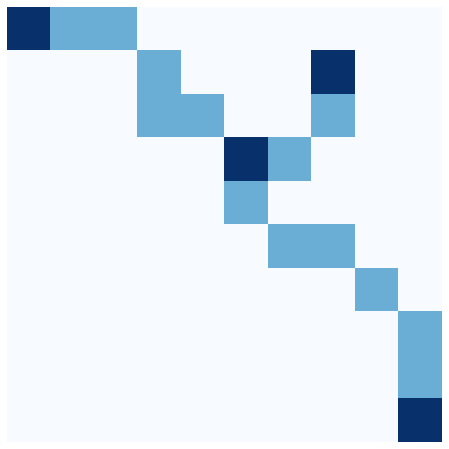

In [ ]:
guess = threshold(dist)
guess[tuple(np.array(points).T)] = 2
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.imshow(guess, cmap='Blues')
ax.axis('off')

#Load in tower data(from osm for now)

In [ ]:
dirs = ['sierra_leone', 'malawi', 'ghana']
country_dict = {'sierra_leone': 'SL', 'ghana':'GH', 'malawi': 'MW'}
base_path = os.path.join('/content', 'drive', 'My Drive', 'PyPSA_Africa_images')
out_path = os.path.join(base_path, 'MAXAR_256')

for country in dirs:
    country_code = country_dict[country]
    max_ratio = 1.
    print(f"Making Examples for {country}!")

    # assess satellite imagery

    data_path = os.path.join(base_path, 'maxar', country, 'raw')

    #coverage_polygon = make_examples.make_polygon_list(data_path)
    lines_file = os.path.join(data_path, f"{country_code}_raw_lines.geojson")

    line_df = gpd.read_file(lines_file)
    num_lines = len(line_df)
    #max_lines = int(max_ratio*num_towers)


gh_line_df = line_df.loc[line_df['Country']=='GH']
gh_line_df.head()

In [ ]:
dirs = ['sierra_leone', 'malawi', 'ghana']
country_dict = {'sierra_leone': 'SL', 'ghana':'GH', 'malawi': 'MW'}
base_path = os.path.join('/content', 'drive', 'My Drive', 'PyPSA_Africa_images')
out_path = os.path.join(base_path, 'MAXAR_256')

for country in dirs:
    country_code = country_dict[country]
    max_ratio = 1.
    print(f"Making Examples for {country}!")

    # assess satellite imagery

    data_path = os.path.join(base_path, 'maxar', country, 'raw')

    #coverage_polygon = make_examples.make_polygon_list(data_path)
    towers_file = os.path.join(data_path, f"{country_code}_raw_towers.geojson")

    tower_df = gpd.read_file(towers_file)
    num_towers = len(tower_df)
    max_towers = int(max_ratio*num_towers)

Making Examples for sierra_leone!
Making Examples for malawi!
Making Examples for ghana!


##ghana 10 tower step by step

In [ ]:
gh_twr_df = tower_df.loc[tower_df['Country']=='GH']
gh_twr_df.head()

,id,tags.power,tags.material,tags.height,tags.structure,tags.line_management,Type,Country,geometry
0,3.063476e+09,tower,None,None,None,None,Node,GH,POINT (-1.96697 6.67105)
1,3.063707e+09,tower,None,None,None,None,Node,GH,POINT (-2.11938 7.70032)
2,6.299353e+09,tower,None,None,None,None,Node,GH,POINT (-0.31116 6.17326)
3,3.063970e+09,tower,None,None,None,None,Node,GH,POINT (-2.34855 8.85587)
4,3.063970e+09,tower,None,None,None,None,Node,GH,POINT (-2.41069 8.92856)


In [ ]:
gh_coords = gh_twr_df['geometry']
gh_coords.head()
print(len(gh_coords))

In [ ]:
## select first 10 random towers to explore space
gh_coord_test = gh_coords[0:9]

In [ ]:
# return list of tower coords in lon lat format
unpack_all_tower_coords(gh_coord_test)

In [ ]:
#return arrays of straight line distance between each tower considered
m_distance_sline_all_towers(gh_coord_test)

In [ ]:
#plot scatter as lon lat for x y
gdf = gh_twr_df[0:10]
gdf.plot(markersize = 10, figsize = (8,8))

### create gridded representation

In [ ]:
n_cells=30 # how many cells for range of x values investigated - can be customized for y if needed

# total area for the grid
xmin, ymin, xmax, ymax= gdf.total_bounds
cell_size = (xmax-xmin)/n_cells
# projection of the grid
crs = "+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs"
# create the cells in a loop
grid_cells = []
for x0 in np.arange(xmin, xmax+cell_size, cell_size ):
    for y0 in np.arange(ymin, ymax+cell_size, cell_size):
        # bounds
        x1 = x0-cell_size
        y1 = y0+cell_size
        grid_cells.append( shapely.geometry.box(x0, y0, x1, y1)  )
cell = gpd.GeoDataFrame(grid_cells, columns=['geometry'],
                                 crs=crs)

In [ ]:
print(len(grid_cells))
print(cell_size)
print(cell.total_bounds)

2046
0.07984443333333334
[-2.51058793  5.6814062  -0.0354105  10.9511388 ]


(-2.55051015, 0.08435615000000003, 5.424609234999947, 11.074142465000003)

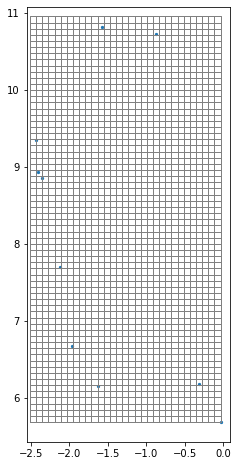

In [ ]:
# plot grids on top of scatter
ax = gdf.plot(markersize=5, figsize=(12, 8))
plt.autoscale(False)
cell.plot(ax=ax, facecolor="none", edgecolor='grey')
ax.axis("on")

In [ ]:
## plot gridded representation on folium
import folium
guess_gdf = gdf
minx, miny, maxx, maxy = list(guess_gdf.bounds.iloc[0])
bounds = ((miny, minx), (maxy, maxx))

df = cell
m = folium.Map(control_scale=True)
m.fit_bounds(bounds)
folium.GeoJson(guess_gdf).add_to(m)
for _, r in df.iterrows():
    # ssimplify representation of each cell for better visualization
    sim_geo = gpd.GeoSeries(r['geometry']).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j,
                           style_function=lambda x: {'fillColor': 'orange'})
    geo_j.add_to(m)
m

### merge gridded and original

In [ ]:
merged = gpd.sjoin(gdf, cell, how='left', op='within')
merged
clean_merge = merged.drop(labels =['tags.power', 'tags.material', 'tags.height', 'tags.structure',
       'tags.line_management', 'Type', 'Country'], axis = 1)

merged2 = clean_merge.dropna(axis = 0, how = 'any')
merged2

###create binary cell representation

In [ ]:
#TODO- MAKE UPDATED VERSION WHICH ONLY TAKES CELL DF AS INPUT
def pts_df_to_2d_target_array(cell, n_cells):

  gdf = cell
  xmin, ymin, xmax, ymax= gdf.total_bounds
  cell_size = (xmax-xmin)/n_cells

  # define number of x and y cells used for indexing
  nxcell = int((xmax - xmin) / cell_size)
  nycell = int((ymax - ymin) / cell_size)

  twr_pts_idx = return_idx_twr_gridded(cell, n_cells)

  points = twr_pts_idx
  targets = np.zeros((int(nycell+1), int(nxcell+1)))
  targets[tuple(np.array(points).T)] = 1
  #targets[tuple(np.array(points))] = 1
  #equal costs for all cells - excluding road info etc
  costs = np.ones((int(nycell+1), int(nxcell+1)))

  ## flip to be consistent with original gridded
  t = np.flip(targets, 0)
  c = np.flip(costs, 0)

  return t, c

In [ ]:
guess_gdf

,geometry
same,
0,"MULTILINESTRING ((-2.35090 5.68141, -2.37751 5..."


(-0.5, 29.5, 63.5, -0.5)

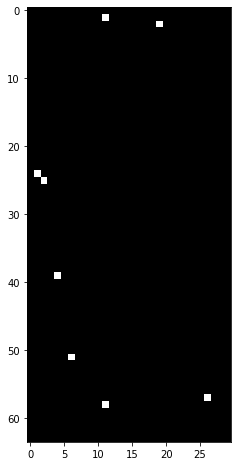

In [ ]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.imshow(targets ,cmap='gray')
#for (j,i),label in np.ndenumerate(targets):
    #ax.text(i,j,f'{label:.2f}', ha='center', va='center', color='gray')
ax.axis('on')

(-2.538533485, -0.16715381500000276, 5.8410950666666155, 11.110827666666607)

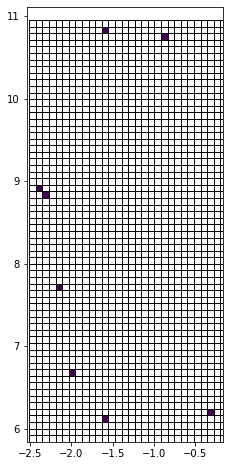

In [ ]:
#plot merged gridded and original with binary celll representation
ax = cell.plot(column='n_twr', figsize=(12, 8), cmap='viridis', vmax=5000, edgecolor="grey")
plt.autoscale(False)
cell.plot(ax=ax, color='none', edgecolor='black')
ax.axis('on')

In [ ]:
twr_pts_idx = return_idx_twr_gridded(cell, n_cells)
twr_pts_idx

[(40, 0), (39, 1), (25, 3), (12, 5), (5, 10), (64, 10), (63, 19), (6, 26)]

###convert to target and cost array

In [ ]:
points = twr_pts_idx
points

[(40, 0), (39, 1), (25, 3), (12, 5), (5, 10), (64, 10), (63, 19), (6, 26)]

In [ ]:
#random costs for comparison
#costs = np.random.rand(*targets.shape)
#costs

'99.00 %'

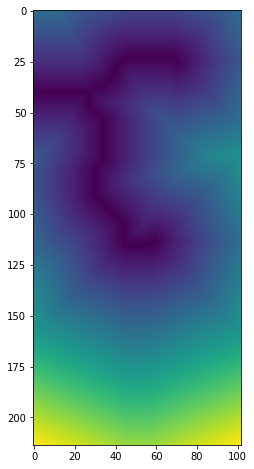

In [ ]:
#plot where most points we want to connect are
start = points[0]
dist = optimise(targets, costs, start, jupyter=True)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.imshow(dist, cmap='viridis')

(-0.5, 101.5, 213.5, -0.5)

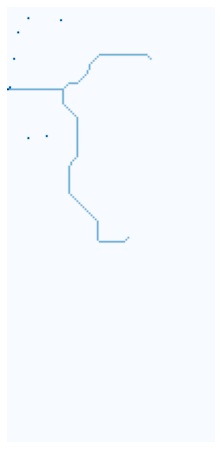

In [ ]:
guess = threshold(dist, cutoff = 0.0)
guess[tuple(np.array(points).T)] = 2
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.imshow(guess, cmap='Blues')
ax.axis('off')

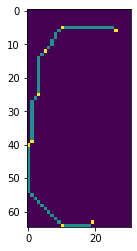

In [ ]:
plt.imshow(guess, cmap='viridis')

(-0.5, 101.5, 213.5, -0.5)

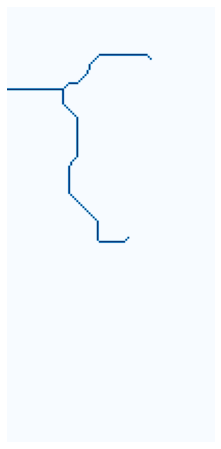

In [ ]:
guess = threshold(dist, cutoff = 0.0)
#guess[tuple(np.array(points).T)] = 2
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.imshow(guess, cmap='Blues')
ax.axis('off')

### skeletonize network output guess

In [ ]:
guess_skel = thin(guess)
#plt.imshow(skel_guess)

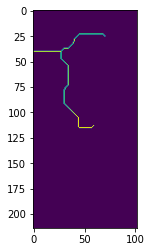

In [ ]:
plt.imshow(guess_skel)

# ghana 10 towers

In [ ]:
n_cells = 30
gdf = gh_twr_df[0:10]
network_guess, thinned_network_guess = network_inference_simple(gdf, n_cells )

(-0.5, 29.5, 63.5, -0.5)

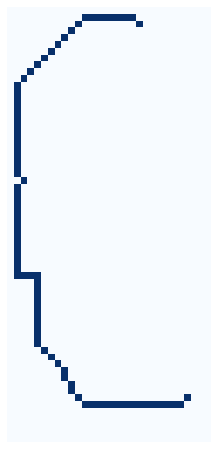

In [ ]:
#network_guess[tuple(np.array(points).T)] = 2
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.imshow(network_guess, cmap='Blues')
ax.axis('off')

In [ ]:
thinned_network_guess.shape

(64, 30)

# ghana full country simplified

In [ ]:
gdf = gh_twr_df
n_cells = 300
network_guess, thinned_network_guess = network_inference_simple(gdf, n_cells )

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
__main__:21: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: +proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 + ...

/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


'99.00 %'

(-0.5, 300.5, 362.5, -0.5)

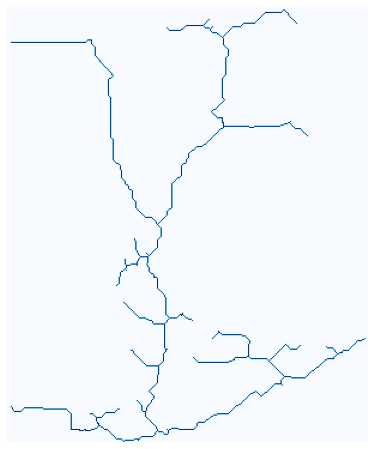

In [ ]:
#network_guess[tuple(np.array(points).T)] = 2
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.imshow(network_guess, cmap='Blues')
ax.axis('off')

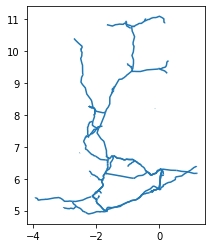

In [ ]:
gh_line_df.plot()

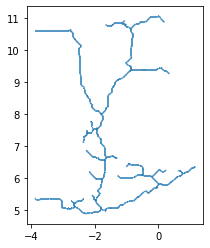

In [ ]:
lines_guess_gdf = convert_guess_to_gdf_multilines(thinned_network_guess, gdf)
lines_guess_gdf.plot()

In [ ]:
lines_guess_gdf

In [ ]:
## plot OSM network
import folium
guess_gdf = lines_guess_gdf
minx, miny, maxx, maxy = list(guess_gdf.bounds.iloc[0])
bounds = ((miny, minx), (maxy, maxx))

m = folium.Map(control_scale=True)
m.fit_bounds(bounds)
folium.GeoJson(guess_gdf).add_to(m)
folium.GeoJson(gh_line_df, style_function = lambda x: {'color': 'orange'}).add_to(m)
m

# Ghana Full Example

In [ ]:
gdf = gh_twr_df
n_cells = 400
network_guess, thinned_network_guess = network_inference_simple(gdf, n_cells )

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
__main__:21: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: +proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 + ...

/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


'99.00 %'

(-0.5, 400.5, 483.5, -0.5)

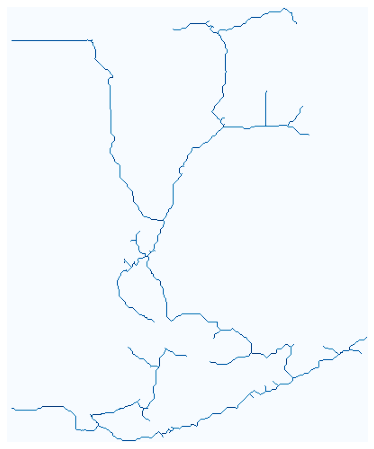

In [ ]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.imshow(network_guess, cmap='Blues')
ax.axis('off')

In [ ]:
## plot OSM network
import folium
guess_gdf = lines_guess_gdf
minx, miny, maxx, maxy = list(guess_gdf.bounds.iloc[0])
bounds = ((miny, minx), (maxy, maxx))

m = folium.Map(control_scale=True)
m.fit_bounds(bounds)
folium.GeoJson(guess_gdf).add_to(m)
folium.GeoJson(gh_line_df, style_function = lambda x: {'color': 'orange'}).add_to(m)
m

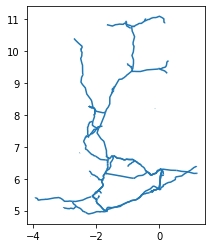

In [ ]:
gh_line_df.plot()

#build accuracy function: todo

have to us eequivalent n_lines

In [ ]:

gdf = gh_line_df
# total area for the grid
xmin, ymin, xmax, ymax= gdf.total_bounds
cell_size = (xmax-xmin)/n_cells
# projection of the grid
crs = "+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs"
# create the cells in a loop
grid_cells = []
for x0 in np.arange(xmin, xmax+cell_size, cell_size ):
    for y0 in np.arange(ymin, ymax+cell_size, cell_size):
        # bounds
        x1 = x0-cell_size
        y1 = y0+cell_size
        grid_cells.append( shapely.geometry.box(x0, y0, x1, y1)  )
cell = gpd.GeoDataFrame(grid_cells, columns=['geometry'],
                                 crs=crs)

In [ ]:
merged = gpd.sjoin(gdf, cell, how='left', op='within')
merged

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if self.run_code(code, result):
__main__:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: +proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 + ...



,Type,Length,id,tags.power,tags.cables,tags.voltage,tags.frequency,Country,geometry,index_right
0,Way,55086.561391,282576409.0,line,6,161000,50,GH,"LINESTRING (0.06071 6.29383, 0.06255 6.29198, ...",NaN
1,Way,11846.890723,672613736.0,line,6,161000,50,GH,"LINESTRING (0.00266 5.69650, 0.00195 5.69827, ...",NaN
2,Way,719.059998,672613759.0,line,3,161000,None,GH,"LINESTRING (0.03691 6.03796, 0.03714 6.04117, ...",150439.0
3,Way,53.841728,633724559.0,line,None,None,None,GH,"LINESTRING (-0.24722 5.61765, -0.24713 5.61772...",139736.0
4,Way,140.349036,644998912.0,line,None,None,None,GH,"LINESTRING (-0.23118 5.62896, -0.23080 5.62912...",140222.0
...,...,...,...,...,...,...,...,...,...,...
329,Way,86.239864,632224429.0,line,None,None,None,GH,"LINESTRING (-0.23564 5.61149, -0.23559 5.61175...",140220.0
330,Way,1220.363328,674032304.0,line,3,161000,50,GH,"LINESTRING (-1.09872 5.21685, -1.09479 5.21862...",107695.0
331,Way,43.052402,673695266.0,line,3,161000,None,GH,"LINESTRING (-1.77954 5.96358, -1.77960 5.96320)",82048.0
332,Way,622.328275,672622689.0,line,3,161000,50,GH,"LINESTRING (-0.10178 5.65506, -0.10444 5.65407...",145074.0


In [ ]:
clean_merge = merged.drop(labels =['tags.power', 'tags.cables', 'tags.voltage', 'tags.frequency',
        'Type', 'Country'], axis = 1)


In [ ]:
merged2 = clean_merge.dropna(axis = 0, how = 'any')
merged2

,Length,id,geometry,index_right
2,719.059998,672613759.0,"LINESTRING (0.03691 6.03796, 0.03714 6.04117, ...",150439.0
3,53.841728,633724559.0,"LINESTRING (-0.24722 5.61765, -0.24713 5.61772...",139736.0
4,140.349036,644998912.0,"LINESTRING (-0.23118 5.62896, -0.23080 5.62912...",140222.0
6,56.020128,972938080.0,"LINESTRING (-1.05133 9.65819, -1.05170 9.65786)",109495.0
11,712.260332,695636438.0,"LINESTRING (-2.29301 6.90955, -2.29043 6.90727...",62721.0
...,...,...,...,...
328,18.012669,634961758.0,"LINESTRING (-0.23700 5.61237, -0.23689 5.61248)",140220.0
329,86.239864,632224429.0,"LINESTRING (-0.23564 5.61149, -0.23559 5.61175...",140220.0
330,1220.363328,674032304.0,"LINESTRING (-1.09872 5.21685, -1.09479 5.21862...",107695.0
331,43.052402,673695266.0,"LINESTRING (-1.77954 5.96358, -1.77960 5.96320)",82048.0


In [ ]:
# make a simple count variable that we can sum
merged2['n_lines']=1
# Compute stats per grid cell -- aggregate fires to grid cells with dissolve
dissolve = merged2.dissolve(by="index_right", aggfunc="count")
# put this into cell
cell.loc[dissolve.index, 'n_lines'] = dissolve.n_lines.values

/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [ ]:
ax = cell.plot(column='n_lines', figsize=(12, 8), cmap='viridis', vmax=5000, edgecolor="grey")
plt.autoscale(False)
cell.plot(ax=ax, color='none', edgecolor='black')
ax.axis('on')

In [ ]:
a = lines_df_to_2d_target_array(cell, n_cells)

In [ ]:
a

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]), array([[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]]))